# Neural Networks II
G. Richards
(2016, 2018, 2020, 2022)
[Ivezic 9.8](https://www.astroml.org/book_figures/chapter9/index.html) and [Geron](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1492032646/ref=sr_1_5?dchild=1&keywords=machine+learning&qid=1596499152&sr=8-5).   With updates to my own class from [Stephen Taylor's class at Vanderbilt](https://github.com/VanderbiltAstronomy/astr_8070_s22).


## Contents
* [Preliminaries](#one)
* [Regularization](#two)
* [Batch Normalization](#three)
* [Example: Photo-z With Torch](#four)
* [Example: Fashion MNIST with Keras](#five)
* [Convolutional Neural Networks (CNNs)](#six)
* [Autoencoders](#seven)
* [Generative Adversarial Networks (GANs)](#eight)

## Preliminaries <a class="anchor" id="one"></a>

If you didn't already last time, let's install some software, including the two big Deep Learning packages out there. [Tensorflow](https://www.tensorflow.org/) and [PyTorch](https://pytorch.org/)-- the rivalry essentially boils down to Google versus Facebook.  See the cells below.  Go ahead and do this while you are waiting for lecture to start.

While you are waiting for software to install, please go to https://playground.tensorflow.org/

Try the default. Note how the first layer identifies simple patterns and the second layer combines those to make more complex patterns. It also finds a solution quite quickly. (Note also that it won't stop on its own. Hit pause when you are happy with the solution it has converged on.)
Try a ReLU activation function. Much faster, but with a "boxy" solution.
See what happens when there is only 1 hidden layer with 3 neurons. Reset and run it multiple times.
Compare learning rate 0.001 to 1.0.
Now try just 2 neurons (with learning rate back at 0.3).
Now try 8 neurons.
Lastly try the spiral dataset with 4 hidden layers, each with 8 neurons. Run it for at least 1000-1500 epochs -- until it gets the answer "right" (make sure that your computer is plugged in and properly cooled!) This illustrates the vanishing gradient problem.
Do this again after lecture.

See Problem 10.1 in Geron

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
from platform import python_version
import numpy
import scipy
import matplotlib
import sklearn
print("python version ",python_version(), " core programming language")
print("numpy version ",numpy.__version__, " efficient array operations")
print("scipy version ",scipy.__version__, " scientific computing tools")
print("matplotlib version ",matplotlib.__version__, " plotting and visualization")
print("sklearn version ",sklearn.__version__, " machine learning")

In [ ]:
import tensorflow as tf
from tensorflow import keras
print("tensorflow version ",tf.__version__)
print("keras version ",keras.__version__)

In [ ]:
import torch
print("torch version ",torch.__version__)

---

## Regularization  <a class="anchor" id="two"></a>

Just as we can use regularization for standard regression and classification tasks, so too can we with neural networks.  

Not only can we apply the usual $L1$ (LASSO) or $L2$ (Ridge) regularization techniques, we can also use **dropout** which, as the name indicates, causes some neurons to be temporarily "dropped out" during training (usually by setting some probability for that to happen, typically 10-50%). After training, all of the neurons are used.

*Geron* explains this in terms of a company needing to try to figure out how to adapt to a crucial employee being out sick for a period of time.  In the end, it can make the company stronger as more people (neurons) are able to handle certain parts of the process.

One form of regularization is  **early stopping**.  This will determine when there hasn't been any improvement in the validation set for `patience` epochs and stop the fitting.  It also uses the "best" weights and just the "last" weights.

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(X_test.shape)

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

mse_test = model.evaluate(X_test, y_test)

#X_new = X_test
y_pred = model.predict(X_test)

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Note that we told it that it could run for as many as 100 epochs if it wanted to, but it stopped sooner.

Now we can plot the results.

In [ ]:
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.gca().set_xlabel("Epoch")
plt.show()

Here's an example of how to do regularization with [dropout](https://en.wikipedia.org/wiki/Dilution_(neural_networks)).

![DropoutDiagram](https://miro.medium.com/max/1400/1*tvcv2PT3cBAmUtZzQTmjeQ.png)

In [ ]:
#Back to the fashion MNIST data
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

In [ ]:
plt.imshow(X_train[0], cmap="binary", origin="upper")
plt.axis('off')
plt.show()

In [ ]:
#Dropout example
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2), #20% chance of neuron stuck in off position
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid))

## Batch normalization  <a class="anchor" id="three"></a>

Just as it is often necessary to normalize or standardize our features, sometimes it is helpful to do the same to the output of the hidden layers.  This is called **[batch normalization](https://en.wikipedia.org/wiki/Batch_normalization)** and is done before passing the data to the activation function.  It make the process more stable and can also make it faster. 

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.summary()

In some cases you might want to do the batch normalization before applying the activation function.  Here we also turn off the bias parameter because it ends up not being needed and just wastes a parameter.

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid))

Now let's use cross validation to determine the best options.  Here we have so many that we'll use [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) instead of `GridSearchCV`.

First we need to do some preprocessing to get sklearn and keras to talk nicely to each other.

Start by building the model in a way that the hyperparameters are themselves parameters, then wrap that model in a way that we can use it within sklearn.

See
https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb

In [ ]:
def build_model(n_hidden=1, n_neurons=10, learning_rate=3e-3, input_shape=[28,28]):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=input_shape))
    for layer in range(n_hidden): #Because the number of hidden layers is a parameter
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(10, activation="softmax")) #Output layer
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [ ]:
keras_class = keras.wrappers.scikit_learn.KerasClassifier(build_model)
#Note that there is also a KerasRegressor for regression problems.

keras_class can now be used with in sklearn in the same way as any other classifier. For example:

In [ ]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    #"n_hidden": [0, 1, 2, 3],
    "n_hidden": (0, 1),
    #"n_neurons": np.arange(1, 30), #This would take too long for class!
    "n_neurons": (5,10),
    #"learning_rate": reciprocal(3e-4, 3e-2) #Not quite sure what this does, but it makes it take forever!
}

rnd_search_cv = RandomizedSearchCV(keras_class, param_distribs, n_iter=10, cv=3, verbose=2)

In [ ]:
#If you also wanted to try different activation functions, here they are
[m for m in dir(keras.layers) if "relu" in m.lower()]

Note that we are doing 3-fold cross validation, so the validation set isn't being used for training, just for early stopping.

---

## Example: Photo-z with Torch <a class="anchor" id="four"></a>

An important problem in galaxy imaging is being able to use observed galaxy color data to estimate its redshift. This is sometimes called "photo-z". Now, on your humble computer, you will build a deep neural network that is trained on a sample of SDSS galaxy color data. You'll see that `pytorch` makes this quite easy.

Read in and prepare the SDSS data.

Let's define a little helper class that will make our network. It is initialized with a given number of neurons in the single hidden layer. These neurons in the hidden layer connect to $5$ input variables (colors) and spits out 1 variable (redshift). You can also see that it uses ReLU activation for the neurons.

Do a train-test split on the data.

Define a function to train the neural network. This looks like a lot of code, but the first block is the key. The network will have $4$ neurons in the hidden layer, and will use stochastic gradient descent to train the weights and biases.

Let's train this thing. It should take about five minutes. 

Plot the results.

Not bad. Still, this was a relatively simple fully-connected network. Other problems will require more complexity...

---

## Convolutional Neural Networks (CNNs) <a class="anchor" id="five"></a>

Recent interest in neural networks surged in 2012 when a team using a deep [convolutional neural network (CNN)](https://en.wikipedia.org/wiki/Convolutional_neural_network) acheived record results classifying objects in the [ImageNet](http://image-net.org/) data set.

The idea behind CNNs is inspired by human visual perception.  Each neuron in your visual cortex doesn't "see" all of what your eye can see at once and some neuron are more sensitive to one pattern over another (e.g., horizontal lines vs. vertical lines).  

Moreover, the simplest deeply connected neural networks would choke on "real" data which has far more than 28x28 pixels and would require following tens of millions of connections.  So we use a combination of **convolution** and **pooling** to reduce the dimensionality of the data first.

![Ivezic Figure 9.19](https://www.astroml.org/_images/fig_cnn_1.png)

### Convolutional Layers

In a convolutional layer, each neuron is not connected to each neuron in the previous layer, but only those that are within its "field of view" as defined by a kernel (filter).  We slide the kernel over the input layer and the value in the next layer depends only on those pixels.

![](https://miro.medium.com/max/4800/1*GcI7G-JLAQiEoCON7xFbhg.gif)

![Convolutional Layer](https://miro.medium.com/max/1400/1*wLlXFtWI--7knyQT2wlhMg.png)

Choosing a filter (kernel) with a certain pattern can help recognize certain types of features (like horizontal aor vertical lines).

![vertical filter](https://miro.medium.com/max/1338/1*7IEbBib7Yc7qST5IGQoYXA.jpeg)

![horizontal filter](https://miro.medium.com/max/1238/1*PSSAaH2pZbl5bK3Ef_zk4A.jpeg)

The purpose of the convolutional layers is really to capture high-level features in the images, like edges. 

It is common to follow the convolutional layer by a so-called "pooling layer", essentially to reduce the amount of data that needs to be processed.  The full architecture of a CNN might look something like this:
![CNN Example](https://www.researchgate.net/profile/Xian_Wei2/publication/331986652/figure/fig1/AS:740547106988032@1553571597647/The-classic-structure-of-CNN-It-consists-of-two-modules-Feature-extraction-module-and.ppm)

Where the pooling layers are reducing the number of pixels by averaging, summing, taking the max, etc.:

![Pooling example](https://miro.medium.com/max/1000/1*ydNsGDxMldAiq7b96GDQwg.jpeg)

When you are done, the output gets feed into a regular, fully connected neural network which outputs the predictions.

This is clearly much more sophisticated than our basic perceptron. "Deep" networks consist of tens of layers with thousands of neurons. These large networks have become usable thanks to two breakthroughs: the use of sparse layers and the power of graphics processing units (GPUs).

The sparse layers or convolutional layers in a deep network contain a large number of hidden nodes but very few synapses. The sparseness arises from the relatively small size of a typical convolution kernel (15x15 is a large kernel), so a hidden node representing one output of the convolution is connected to only a few input nodes. Compare this the our previous perceptron, in which every hidden node was connected to every input node.

Even though the total number of connections is greatly reduced in the sparse layers, the total number of nodes and connections in a modern deep network is still enormous. Luckily, training these networks turns out to be a great task for GPU acceleration.

For further study, there are lots of resources for CNNs online.  For example, see
https://medium.com/analytics-vidhya/convolutional-neural-networks-cnn-explained-step-by-step-69137a54e5e7
    
Now let's see a worked example of a CNN.

### CNN Example using Fashion MNIST

See https://github.com/ageron/handson-ml2/blob/master/14_deep_computer_vision_with_cnns.ipynb

As before, we'll use the **Fashion MNIST data set**. The next cells load the data, define test, trainging, and validation sets; normalize the data; display an example image; list the possible target values ($y$), and show a 4x10 grid of examples.

In [ ]:
keras.backend.clear_session() #Make sure that we are starting a new model and not adding to an earlier one
np.random.seed(42) #Set the numpy and tensorflow random seeds so that we all get the same answer
tf.random.set_seed(42)

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

print(X_train_full.shape)
print(X_test.shape)

X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

This data set is a huge collection of images of items of clothing.

In [ ]:
# Let's make a list of class names that we can refer to.
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Plot 4x10 array of images from the Fashion MNIST database
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest", origin='upper')
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

We'll use `tensorflow` on this data set, through it's handy API `keras`. Since these are images and we want to preserve contextual information like edges, we'll build a CNN.

Normalize and prepare the data to pass into a network.

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std


# Need to reshape for CNN
X_train = X_train[:, :, :, np.newaxis]
X_valid = X_valid[:,  :, :, np.newaxis]
X_test = X_test[:, :, :, np.newaxis]

print(len(X_train))
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

The next cell looks like a lot, but really it is just a sequential declaration of different types of layer in the network. It is a combination of **2D Convolution layers** (feature finding), **Max Pooling layers** (data reduction), followed by some **Dense layers** (fully-connected layers at the end of the network for classification) and some **Dropout** incorporated to strengthen the overall network and make sure all the neurons are actually pulling their weight.

In [ ]:
model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[28, 28, 1]),
    keras.layers.Conv2D(filters=64, kernel_size=7, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),  
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])   

In [ ]:
print(model.summary())

**That's right...your CNN has ~1.5 million parameters that you are going to try to optimize on your machine...**

We'll only go through one epoch of optimization, but hopefully that will be enough to get us above $50\%$ accuracy.

In [ ]:
#### This may take a while! Hopefully no more than 5 minutes for 1 epoch. (<1 min on an M1)
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
clf = model.fit(X_train, y_train, epochs=1, validation_data=(X_valid, y_valid))

In [ ]:
# Evaluate the test set
model.evaluate(X_test, y_test)

Predict values for first 3 test objects

In [ ]:
X_new = X_test[:3]
y_proba = model.predict(X_new).round(2)
print(y_proba)

So, you can see that the output is a probability that the object belongs to each class (which has to sum to 1 across all the classes).  If we just want an "answer", we assign it to the class with the highest probability.

In [ ]:
y_pred = np.argmax(model.predict(X_new), axis=-1) #New way
print(y_pred)
print(np.array(class_names)[y_pred])

Let's plot those and see if the predictions make sense.

In [ ]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest", origin='upper')
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Note that after you fit your model, you can save it and reload it at some later time (which is good because some models might take hours to train!)

In [ ]:
# Save model
model.save("my_keras_model.h5")

# Reload model
model = keras.models.load_model("my_keras_model.h5")

Let's predict the values for 10 random objects. Display them with their actual labels first, then predict and display the predictions.

In [ ]:
idx10 = np.random.choice(np.arange(len(y_test)), size=10, replace=False)
X_new = X_test[idx10]
y_pred = np.argmax(model.predict(X_new), axis=-1)

In [ ]:
#Correct answers (y_test)
plt.figure(figsize=(15, 5))
for index, image in enumerate(X_new):
    plt.subplot(1, 10, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest", origin='upper')
    plt.axis('off')
    plt.title(class_names[y_test[idx10[index]]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.suptitle('ACTUAL LABELS',y=0.7,fontsize=15)
plt.show()

In [ ]:
#Predicted answers (y_pred)
plt.figure(figsize=(15, 5))
for index, image in enumerate(X_new):
    plt.subplot(1, 10, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest", origin='upper')
    plt.axis('off')
    plt.title(class_names[y_pred[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.suptitle('PREDICTED LABELS',y=0.7,fontsize=15)
plt.show()

Now let's see how well this model does overall.

In [ ]:
score = model.evaluate(X_test, y_test)

In [ ]:
X_new = X_test[:10] # to represent "new" images
print(X_new.shape)

y_pred = model.predict(X_new)
print(y_pred)

Use the `history` output to see the improvement in performance with each epoch.

In [ ]:
import matplotlib.pyplot as plt
  
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
  
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'bo', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'bo', label='Training loss') 
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

---

With image data one of the cool things that we can do is to visualize what the kernel in a given convolutional layer is actually doing.

In [ ]:
conv1 = model.layers[0]
weights1 = conv1.get_weights()
len(weights1)

In [ ]:
kernels1 = weights1[0]
kernels1.shape

kernels1_1 = kernels1[:,:,0,0]
kernels1_1.shape

In [ ]:
plt.imshow(kernels1_1)

In [ ]:
test_image = X_test[0, :, :, 0]
plt.imshow(test_image, origin='upper')

---

---

## Autoencoders  <a class="anchor" id="six"></a>

Autoencoders are neural networks that copy their input to their output, but after passing the data through a bottleneck.  For example if there are 28x28 = 784 inputs, there will also be 784 outputs, but there will be one or more (odd, but symmetric) hidden layers with fewer neuron than that.

For example see 

![autoencoder structure](https://miro.medium.com/max/1400/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png)

from
https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798

So, distill our MNIST digits down to the three most important pixels.  Or perhaps the three most important line segments.

You can think of this as doing PCA with a neural network -- breaking our data down into the only the most important features that we actually *need* (finding the intrinsic dimensionality).   In fact, if the network uses only linear (or no) activation functions and $l2$ cost function, then we have exactly PCA.

How might this be useful?  Well, for example we can use it to reconstruct MNIST digits that have had noise added to them:

![autoencoder example](https://miro.medium.com/max/1400/1*SxwRp9i23OM0Up4sEze1QQ@2x.png)

More exciting possibilities are: 

- Using autoencoders for "**unsupervised pretraining**". For example you have data that is only partially labeled (at least not enough to do traditional supervised classification).  We can train an autoencoder on the full data set, then used the encoder part as the base of a regular neural network that is trained on the labeled data that we do have. This is found to be a much more efficient way of initializing weights and biases than starting from random, because you are "cheating" a bit by already figuring out some of the data structure using the autoencoder. See Geron Figure 17.6.
- **[Anomaly detection](https://scikit-learn.org/stable/modules/outlier_detection.html)**, e.g. https://towardsdatascience.com/anomaly-detection-with-autoencoder-b4cdce4866a6 and https://towardsdatascience.com/anomaly-detection-using-autoencoders-5b032178a1ea. See also
https://www.pyimagesearch.com/2020/03/02/anomaly-detection-with-keras-tensorflow-and-deep-learning/ and 
https://towardsdatascience.com/autoencoder-neural-network-for-anomaly-detection-with-unlabeled-dataset-af9051a048.

### Autoencoder Example

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders) and run it on the fashion MNIST data set.

See
https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb

Specifically, we are going to build this:

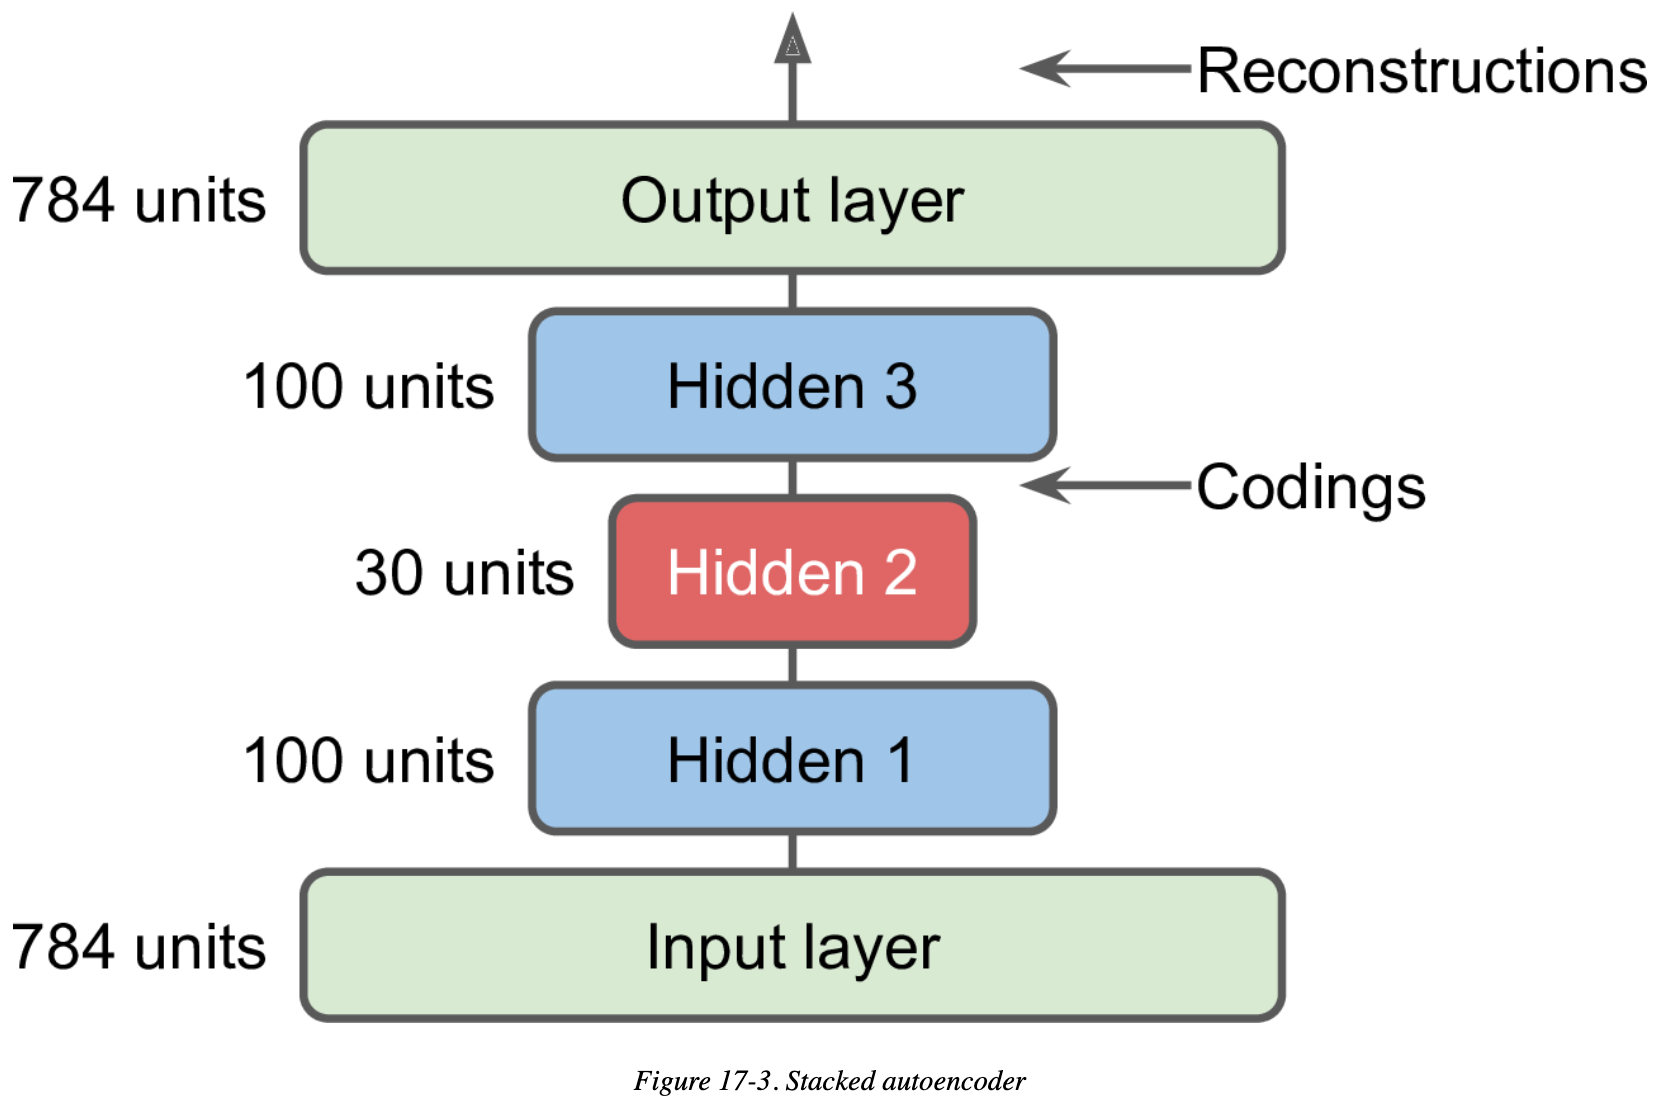

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(lr=1.5), metrics=['accuracy'])
history = stacked_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Let's look at the output reconstructions.

In [ ]:
#Helper function from Geron to show example reconstructions
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary", origin='upper')
        plt.axis("off")  
        
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary", origin='upper')
        plt.axis("off")      

In [ ]:
show_reconstructions(stacked_ae)

Now we can use t-SNE to visualize the clustering

In [ ]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

In [ ]:
# From Geron
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary", origin='upper'),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

---

## Variational Autoencoders  <a class="anchor" id="seven"></a>

More common in astronomy are variational autoencoders, partly because the "latent space" that results from a standard autoencoder doesn't necessarily map continuously to the data (e.g., if your training data don't span the full data space).  We won't go into detail, just realize that these are something that you might try if you were otherwise going to try an autoencoder to tackle your problem.

 **Instead of the encoder layers compressing the data down to a single point in the "latent space", it is mapped to a continuous distribution** (imagine if PCA gave you a probabilistic compression). The prior on this continuous distribution is a Gaussian with mean and variance. ***Therefore the intuition for variational autoencoders is that the mean vector centers the average encoding of the data point, while the variance samples around this average encoding.*** This allows the encoding and decoding to interpolate much more smoothly across the training data. 
 
![Ivezic Figure 9.21](https://www.astroml.org/_images/fig_vae_1.png)


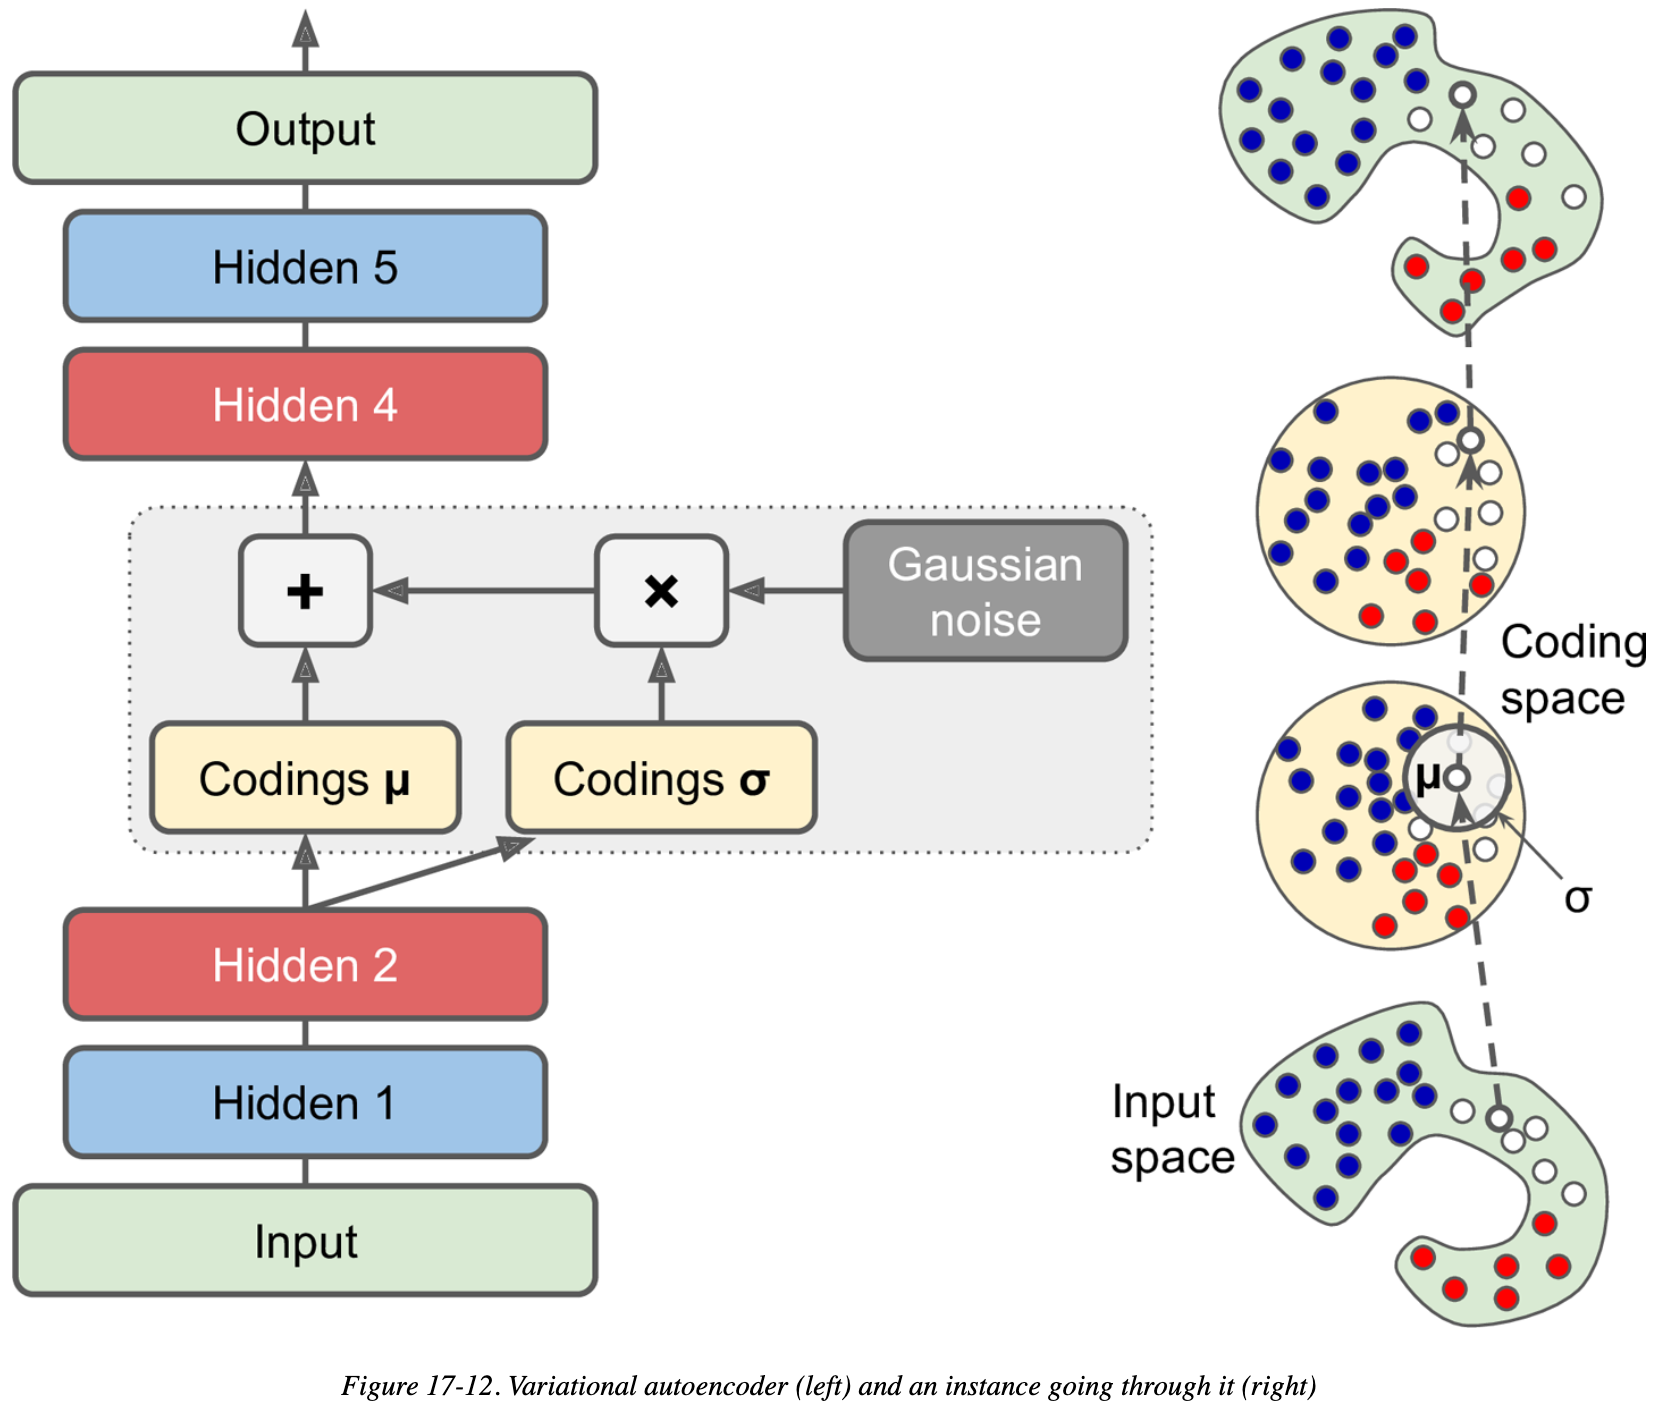

### Variational Autoencoder Example

Let's build a variational autoencoder and train it on a sample of SDSS spectra. We'll switch back to `pytorch`. Grab the data, normalize and prepare for the network, then do a 3:1 train-test split.

(Again, this doesn't currently work on my M1, but may on your computer).

Now define the structure of the variational autoencoder. 
- In the top block you can see that the first layer reduces the $1000$-D input down to $250$.
- We then pass to a $2$D mean and variance layer from which the compressed "latent" parameters can be probabilistically drawn. This means that we compressing down from a 1000 flux channels to a 2D compressed representation.
- The decoding layers decompress the sampled latent parameters and scale back up to the full 1000 flux channel dimensions.

The loss is a modified version of the usual MSE, where we use the **Kullback-Leibler divergence** to asses how close the latent parameter distribution is to a Gaussian. 

Another large block that is essentially just training the network.

Let's train this thing! (Takes less than a minute)

The spectra above are generated from our variational autoencoder. As mentioned, the encoder was limited to two components (2D compressed latent space). As neurons are progressively activated in the latent space, we generate a smooth transition from spectra consistent with quiscent to star-forming galaxies. The numbers in each panel indicate the activation value of the two neurons in the latent space.

---

### Variational Autoencoder Example (Keras based)

Until GANs (see below), this is how you would have generated fake images.

In [ ]:
K = keras.backend

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=['accuracy'])
history = variational_ae.fit(X_train, X_train, epochs=20, batch_size=128,
                             validation_data=(X_valid, X_valid))

Now generate some fake images.  Note that the goal here is NOT to teach you how to create "deep fakes", but rather to build up to scientifically useful applications of GANs.

In [ ]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary", origin='upper')
        plt.axis("off")

In [ ]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

---

## Generative Adversarial Networks (GANs)  <a class="anchor" id="eight"></a>

GANs are pure evil, see
https://thispersondoesnotexist.com.  The picture you see is not a real person-- it was generated by a neural network.

But they are also brilliant, incredibly useful, and relatively new (2014).  The idea builds logically on autoencoders.

1. We have a generator (like the decoder part of an autoencoder) that can produce fake data (e.g., an image). 
2. Then we have a discriminator (a standard binary classifier) that tries to distinguish fake data from real.  
3. Then the generator learns to produce more and more accurate images to trick the discriminator -- without ever seeing any real images -- it just has the feedback from the discriminator.
4. We are pitting artifical neural networks against themselves to make them stronger. What could possibly go wrong, right?

![](https://learning.oreilly.com/library/view/java-deep-learning/9781788997454/assets/2cf8b4f1-7163-4af1-aa4b-6066329d554a.png)


[Geron17-15GAN.png](attachment:Geron17-15GAN.png)

[Geron17-18GANexample.png](attachment:Geron17-18GANexample.png)


For more, see
https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29

Astronomy has seen some interesting uses of autoencoders and GANs in recent years.  For example:
    
- https://arxiv.org/abs/1702.00403    
- https://www.aanda.org/articles/aa/full_html/2017/07/aa30240-16/aa30240-16.html
- https://arxiv.org/pdf/1711.03121.pdf
- https://arxiv.org/pdf/1812.02183.pdf

### Generative Adversarial Network (GAN) example

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)                     # not shown
        plt.show()  

In [ ]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)

Geron then runs the GAN for 50 epochs and discusses why training GANs is so hard and is still an active area of research.

---

More exciting to me is the possibility to use autoencoders for "unsupervised pretraining".  For example you have data that is only partially labeled (at least not enough to do traditional supervised classification).  We can train an autoencoder on the full data set, then used the encoder part as the base of a regular neural network that is trained on the labeled data that we do have.  See Geron Figure 17.6

Also for [anomaly detection](https://scikit-learn.org/stable/modules/outlier_detection.html).
See also
https://www.pyimagesearch.com/2020/03/02/anomaly-detection-with-keras-tensorflow-and-deep-learning/ and 
https://towardsdatascience.com/autoencoder-neural-network-for-anomaly-detection-with-unlabeled-dataset-af9051a048.

The last example will pretend that we have a very large training set, but with only a small fraction of the training set having labels.  So, we will use tranfer learning from a pre-trained autoencoder that "clusters" all of the unlabeled training data to build the base layers of a our classification neural network.

[Geron17-6transferlearning.png](attachment:Geron17-6transferlearning.png)

[Geron](./figures/Geron17-6transferlearning.png)

This is exactly the problem that we have for quasar selection in LSST.  We have about 500k quasars that are labeled (plus labels for stars and galaxies) but those objects don't necessarily represent the full range of objects that we are trying to find.  So, it might help to use this pre-training technique.

We'll do this with Fashion MNIST data set as above.  Let's train the autoencoder with 2/3 of the full training set data (but without the labels!), which is 40k objects.  Then we'll have 10k for the test set, the validation set, and our "B" training set.  Then we'll see how that compares to a regular neural net trained with only the "B" training data.

See 
https://github.com/ageron/handson-ml2/blob/master/11_training_deep_neural_networks.ipynb
and
https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb

In [ ]:
keras.backend.clear_session() #Make sure that we are starting a new model and not adding to an earlier one
np.random.seed(42) #Set the numpy and tensorflow random seeds so that we all get the same answer
tf.random.set_seed(42)

In [ ]:
#We'll use 60% of the sample to do unsupervised training with an autoencoder
#Then 10% each for supervised training, validation, and testing
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
print(len(X_train_full),len(X_test))

In [ ]:
from sklearn.model_selection import train_test_split

X_train_A, X_rest, y_train_A, y_rest = train_test_split(X_train_full, y_train_full, test_size=0.33333, random_state=42)
print(len(X_train_A),len(X_rest))

X_train_B, X_valid, y_train_B, y_valid = train_test_split(X_rest, y_rest, test_size=0.50, random_state=42)
print(len(X_train_B),len(X_valid))

In [ ]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(200, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(200, activation="selu", input_shape=[100]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(lr=1.5), metrics=['accuracy'])
history = stacked_ae.fit(X_train_A, X_train_A, epochs=10,
                         validation_data=(X_valid, X_valid))

In [ ]:
stacked_encoder.summary()

In [ ]:
stacked_decoder.summary()

In [ ]:
stacked_ae.summary()

In [ ]:
stacked_ae.save("autoencoder.h5")

In [ ]:
from sklearn.manifold import TSNE

#Maybe should be X_train_A if want to visualize clustering of autoencoder training results?
#But plot validation objects on top?
#X_valid_compressed = stacked_encoder.predict(X_valid)
X_valid_compressed = stacked_encoder.predict(X_train_A)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

In [ ]:
# From Geron
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
#plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_train_A, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            #mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary", origin='upper'),
            mpl.offsetbox.OffsetImage(X_train_A[index], cmap="binary", origin='upper'),
            #position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
            position, bboxprops={"edgecolor": cmap(y_train_A[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

In [ ]:
model_A = keras.models.load_model("autoencoder.h5") #Read in full autoencoder model
#model_B_on_A = keras.models.Sequential(model_A.layers[:-1]) #Just take the encoder part
#model_B_on_A.add(keras.layers.Dense(10, activation="softmax")) #Now add on a new ouput layer

In [ ]:
#Need to clone model A and set weights otherwise they will be update when fitting model_B_on_A
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1]) #Just take the encoder part
model_B_on_A.add(keras.layers.Dense(10, activation="softmax")) #Now add on a new ouput layer

#Freeze reused layers during first few epochs
#Later will have to unfreeze
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

In [ ]:
#Now need to compile
model_B_on_A.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
#Run for a few epochs
#Here we need the answers; don't use data that trained autoencoder.
#Might not be OK to use test data for validation here?
history2 = model_B_on_A.fit(X_train_B, y_train_B, epochs=10,
                    validation_data=(X_valid, y_valid))

In [ ]:
#Unfreeze reused layers
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

In [ ]:
#Recompile with lower learning rate
#Keep fitting for more epochs
model_B_on_A.compile(loss="sparse_categorical_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=20,
                           validation_data=(X_valid, y_valid))

In [ ]:
model_B_on_A.save("autoencoder_transfer_example.h5")

In [ ]:
model_B_on_A.evaluate(X_test, y_test)

In [ ]:
model_B = keras.models.Sequential() #Instantiate a sequential model
model_B.add(keras.layers.Flatten(input_shape=[28, 28])) #Define the input layer
model_B.add(keras.layers.Dense(300, activation="relu")) #First hidden layer
model_B.add(keras.layers.Dense(100, activation="relu")) #Second hidden layer
model_B.add(keras.layers.Dense(10, activation="softmax")) #Output layer

In [ ]:
#Now need to compile
model_B.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
history_B = model_B.fit(X_train_B, y_train_B, epochs=50,
                           validation_data=(X_valid, y_valid))

In [ ]:
model_B.evaluate(X_test, y_test)

We find that Model B is actually better than Model A on B.  Geron says that this shouldn't be expected to work well with a small dense network.  Need a deeper network (maybe even CNN) to get best reslts.  But this at least shows how it is done.

It is worth noting that we **do** have the answers for the full training set here, but if you did **NOT** then the 84.8% that we got (compared to 85.1%) is pretty darn good!

---

### Other Topics (for self study)

multi-label is like doing several binary classifications at once, so use sigmoid activation function.

One vs. rest

Train faster with mini-batches.  Updates weights N mini-batches times per epoch.
Batches normalize between layers.
